## Make network of all Podslushano groups

In [1]:
from tqdm import tqdm
import pickle
import requests
import json
import time
import logging
from itertools import chain
from collections import Counter
import csv
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

In [30]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [2]:
def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

In [3]:
#read the file with group name, activity type and number of participants
with open('source/podsl_names.txt', 'r') as f:
    #read the text in; results in a list of strings
    podsl_names = [r.strip() for r in f.readlines() if r.strip()]

In [4]:
#make lists by three elements – attributes of one group
podsl_names = list(chunks(podsl_names, 3))

In [5]:
#make DataFrame and name columns
df = pd.DataFrame(podsl_names,columns=['name','activity','users'])

In [6]:
print('Количество групп:',df.shape[0])

Количество групп: 998


In [7]:
#convert string with num of participants unto integer type
df['users_new'] = df['users'].str.replace(r'\D', '').astype(int)

In [8]:
df.head(3)

,name,activity,users,users_new
0,Подслушано – Здесь говорят о тебе,Общество,4 015 622 подписчика,4015622
1,ПОДСЛУШАНО ПЕРМЬ,Городское сообщество,453 759 подписчиков,453759
2,Подслушано Иваново,Городское сообщество,25 670 подписчиков,25670


In [9]:
#sort values in users_new column
df = df.sort_values(by=['users_new'],ascending=False).reset_index(drop=True)
df.head(3)

,name,activity,users,users_new
0,Подслушано – Здесь говорят о тебе,Общество,4 015 622 подписчика,4015622
1,Подслушано | Пошлое 18+ 16+,Эротика,734 173 подписчика,734173
2,Подслушано Метро Москвы,Городское сообщество,633 333 подписчика,633333


In [10]:
def remove_dupl(groups_desc_df):
    '''
    takes in table with groups, renames 
    duplicated groups names and returns a new table
    '''
    duplicated = groups_desc_df[groups_desc_df.duplicated(['name'])]
    print('Количество одинаковых названий групп:',len(duplicated))
    
    #set names as index
    df = groups_desc_df.set_index('name')
    #find duplicated names and remove of duplicated index to unique (group, group1, group2...)
    df.index = df.index + df.groupby(level=0).cumcount().astype(str).replace('0','')

    return df

In [11]:
df = remove_dupl(df)

Количество одинаковых названий групп: 52


In [13]:
#reset index and name column with groups names
df = df.reset_index().rename(columns={'index':'name'})

In [14]:
#check how duplicated names have been renamed
df[df.name.str.match('Подслушано в Рыбинске')]

,name,activity,users,users_new
57,Подслушано в Рыбинске,Интернет-СМИ,148 409 подписчиков,148409
103,Подслушано в Рыбинске1,Городское сообщество,103 323 подписчика,103323
350,Подслушано в Рыбинске2,Городское сообщество,45 167 подписчиков,45167


In [ ]:
#this's a tabel with nodes and their attributes
#df

## Make pairs by groups activity

In [15]:
df_g = df.groupby('activity')['name'].apply(list).reset_index(name='groups')

In [16]:
df_g.head(3)

,activity,groups
0,Автовладельцы,"[Подслушано у ДПС, Подслушано у Водителей Ряза..."
1,Автомобили,"[ПОДСЛУШАНО У ВОДИТЕЛЕЙ. ТВЕРЬ, Подслушано у Д..."
2,Активный отдых,"[Подслушано на отдыхе, Подслушано в Туле и Нов..."


In [17]:
#make a dictionary with activity types as keys
dict_g = dict(df_g.values)

In [19]:
#check values by a key
dict_g['Автовладельцы']

['Подслушано у ДПС',
 'Подслушано у Водителей Рязани #ПУВР',
 'Подслушано Автомобилистов | Владимир',
 'Подслушано в такси',
 'Подслушано у таксистов',
 'Подслушано у водителей|Пушкино,Ивантеевка',
 'Подслушано у водителей Шадринск',
 'Подслушано у водителей в Туле',
 'Подслушано у водителей Тюмень',
 'Муром | Подслушано у водителей 33',
 'Подслушано у водителей, Ижевск - Удмуртия, ИГГС']

In [20]:
def make_pairs(dictionary):
    '''
    takes in dictionary with lists of groups as values 
    and group activity as key,iterate over lists and 
    returns all possible pairs
    '''
    all_possible_pairs = []
    for key, val in tqdm(dictionary.items()):
        if val:
            pair_subset = ([(min(val[i], val[j]), 
                             max(val[i], val[j]), key) 
                             for i in range(len(val)) 
                             for j in range(i+1, len(val))])
            
        all_possible_pairs.extend(pair_subset)
    print('Количество всех возможных пар:', len(all_possible_pairs))
    return all_possible_pairs

In [21]:
pairs_g = make_pairs(dict_g)

100%|██████████| 91/91 [00:00<00:00, 226.12it/s]

Количество всех возможных пар: 132281


In [22]:
#make DataFrame again
pairs_g_df = pd.DataFrame(pairs_g, columns=['node1','node2','activity'])

In [23]:
#edges table
pairs_g_df.head(3)

,node1,node2,activity
0,Подслушано у Водителей Рязани #ПУВР,Подслушано у ДПС,Автовладельцы
1,Подслушано Автомобилистов | Владимир,Подслушано у ДПС,Автовладельцы
2,Подслушано в такси,Подслушано у ДПС,Автовладельцы


In [24]:
#add nodes attribute
#merge with nodes weight
edges = (pd.merge(pairs_g_df, df,
                   how='left', 
                   left_on=['node1','activity'], 
                   right_on = ['name','activity'])
                   .rename(columns={'users_new':'users_new1'})
                   .drop(columns=['name','users']))

edges = (pd.merge(edges, df,
                   how='left', 
                   left_on=['node2','activity'], 
                   right_on = ['name','activity'])
                   .rename(columns={'users_new':'users_new2'})
                   .drop(columns=['name','users']))

In [25]:
#edges
print('Количество ребер:',edges.shape[0])
edges.head(3)

Количество ребер: 132281


,node1,node2,activity,users_new1,users_new2
0,Подслушано у Водителей Рязани #ПУВР,Подслушано у ДПС,Автовладельцы,97840,126013
1,Подслушано Автомобилистов | Владимир,Подслушано у ДПС,Автовладельцы,97309,126013
2,Подслушано в такси,Подслушано у ДПС,Автовладельцы,90174,126013


## Prepare tables for graph

In [26]:
#make name as index for nodes table
nodes_attr = df.set_index('name')

In [27]:
#nodes with attr
print('Количество узлов:',nodes_attr.shape[0])
nodes_attr.head(3)

Количество узлов: 998


,activity,users,users_new
name,,,
Подслушано – Здесь говорят о тебе,Общество,4 015 622 подписчика,4015622
Подслушано | Пошлое 18+ 16+,Эротика,734 173 подписчика,734173
Подслушано Метро Москвы,Городское сообщество,633 333 подписчика,633333


In [28]:
#select nodes by activity type
top_activ = Counter(edges.activity).most_common()
#filter activity types with more than 100 pairs
list_groups = []
for i, ii in top_activ:
    if ii > 100: 
        list_groups.append(i)
        
list_groups

['Городское сообщество',
 'Объявления',
 'Интернет-СМИ',
 'Дискуссионный клуб',
 'Молодёжное движение',
 'Юмор',
 'Образование',
 'Открытая группа',
 'Отношения полов',
 'Общественная организация',
 'Группа коллег',
 'Общество']

In [29]:
#filtered edges for a future graph
filter_edges = edges[edges['activity'].isin(list_groups)]

## Build and plot a graph

In [1]:
#figsize: width, height
#dpi default: 100
plt.figure(figsize=(150,180), facecolor='white', dpi=110)

#create the graph
g = nx.from_pandas_edgelist(filter_edges,'node1', 'node2',
                            create_using=nx.Graph())

#create layout 
##k-скученность (больше число - больше расстояние между нодами) 
##iterations-отдаленность кластеров: 10(разбросаны), 50(скученны)
layout = nx.spring_layout(g, iterations=50, k=0.8) #k=0.35


#draw every node
#MAKE NODE COLOR FOR NODE TYPE (i.e. group activity)
nodes_attr = nodes_attr.reindex(g.nodes())
nodes_attr['activity_cat'] = pd.Categorical(nodes_attr['activity'])

nx.draw_networkx_nodes(g, layout, 
                       nodelist=nodes_attr.index, 
                       node_color=nodes_attr['activity_cat'].cat.codes,
                       cmap=plt.cm.Set3,
                       node_size=4000)


#draw edges
nx.draw_networkx_edges(g, layout,
                       edge_color='#3D3D3D', 
                       width=0.25)


#raise text positions for labels
for l in layout:  
    layout[l][0] += 0.01 #правее
    layout[l][1] += 0.03 #выше
    
nx.draw_networkx_labels(g,layout,
                        font_size=45,
                        font_color='#3D3D3D',
                        font_family='Arial Narrow')

#turn off the axis
plt.axis('off')
plt.savefig('plot_podslushano.png')
plt.show()

NameError: name 'plt' is not defined

<img src="images/plot_podslushano_net_low.png"/>

## Count statistics

In [34]:
#not filtered nodes with attributes
df.head(3)

,name,activity,users,users_new
0,Подслушано – Здесь говорят о тебе,Общество,4 015 622 подписчика,4015622
1,Подслушано | Пошлое 18+ 16+,Эротика,734 173 подписчика,734173
2,Подслушано Метро Москвы,Городское сообщество,633 333 подписчика,633333


In [36]:
#count activity types density
df_counts = pd.DataFrame(Counter(df.activity).most_common(15))
df_counts.columns = ['Сфера сообщества', 'Количество групп']

In [37]:
#plot
plt.rcParams["figure.dpi"] = 150

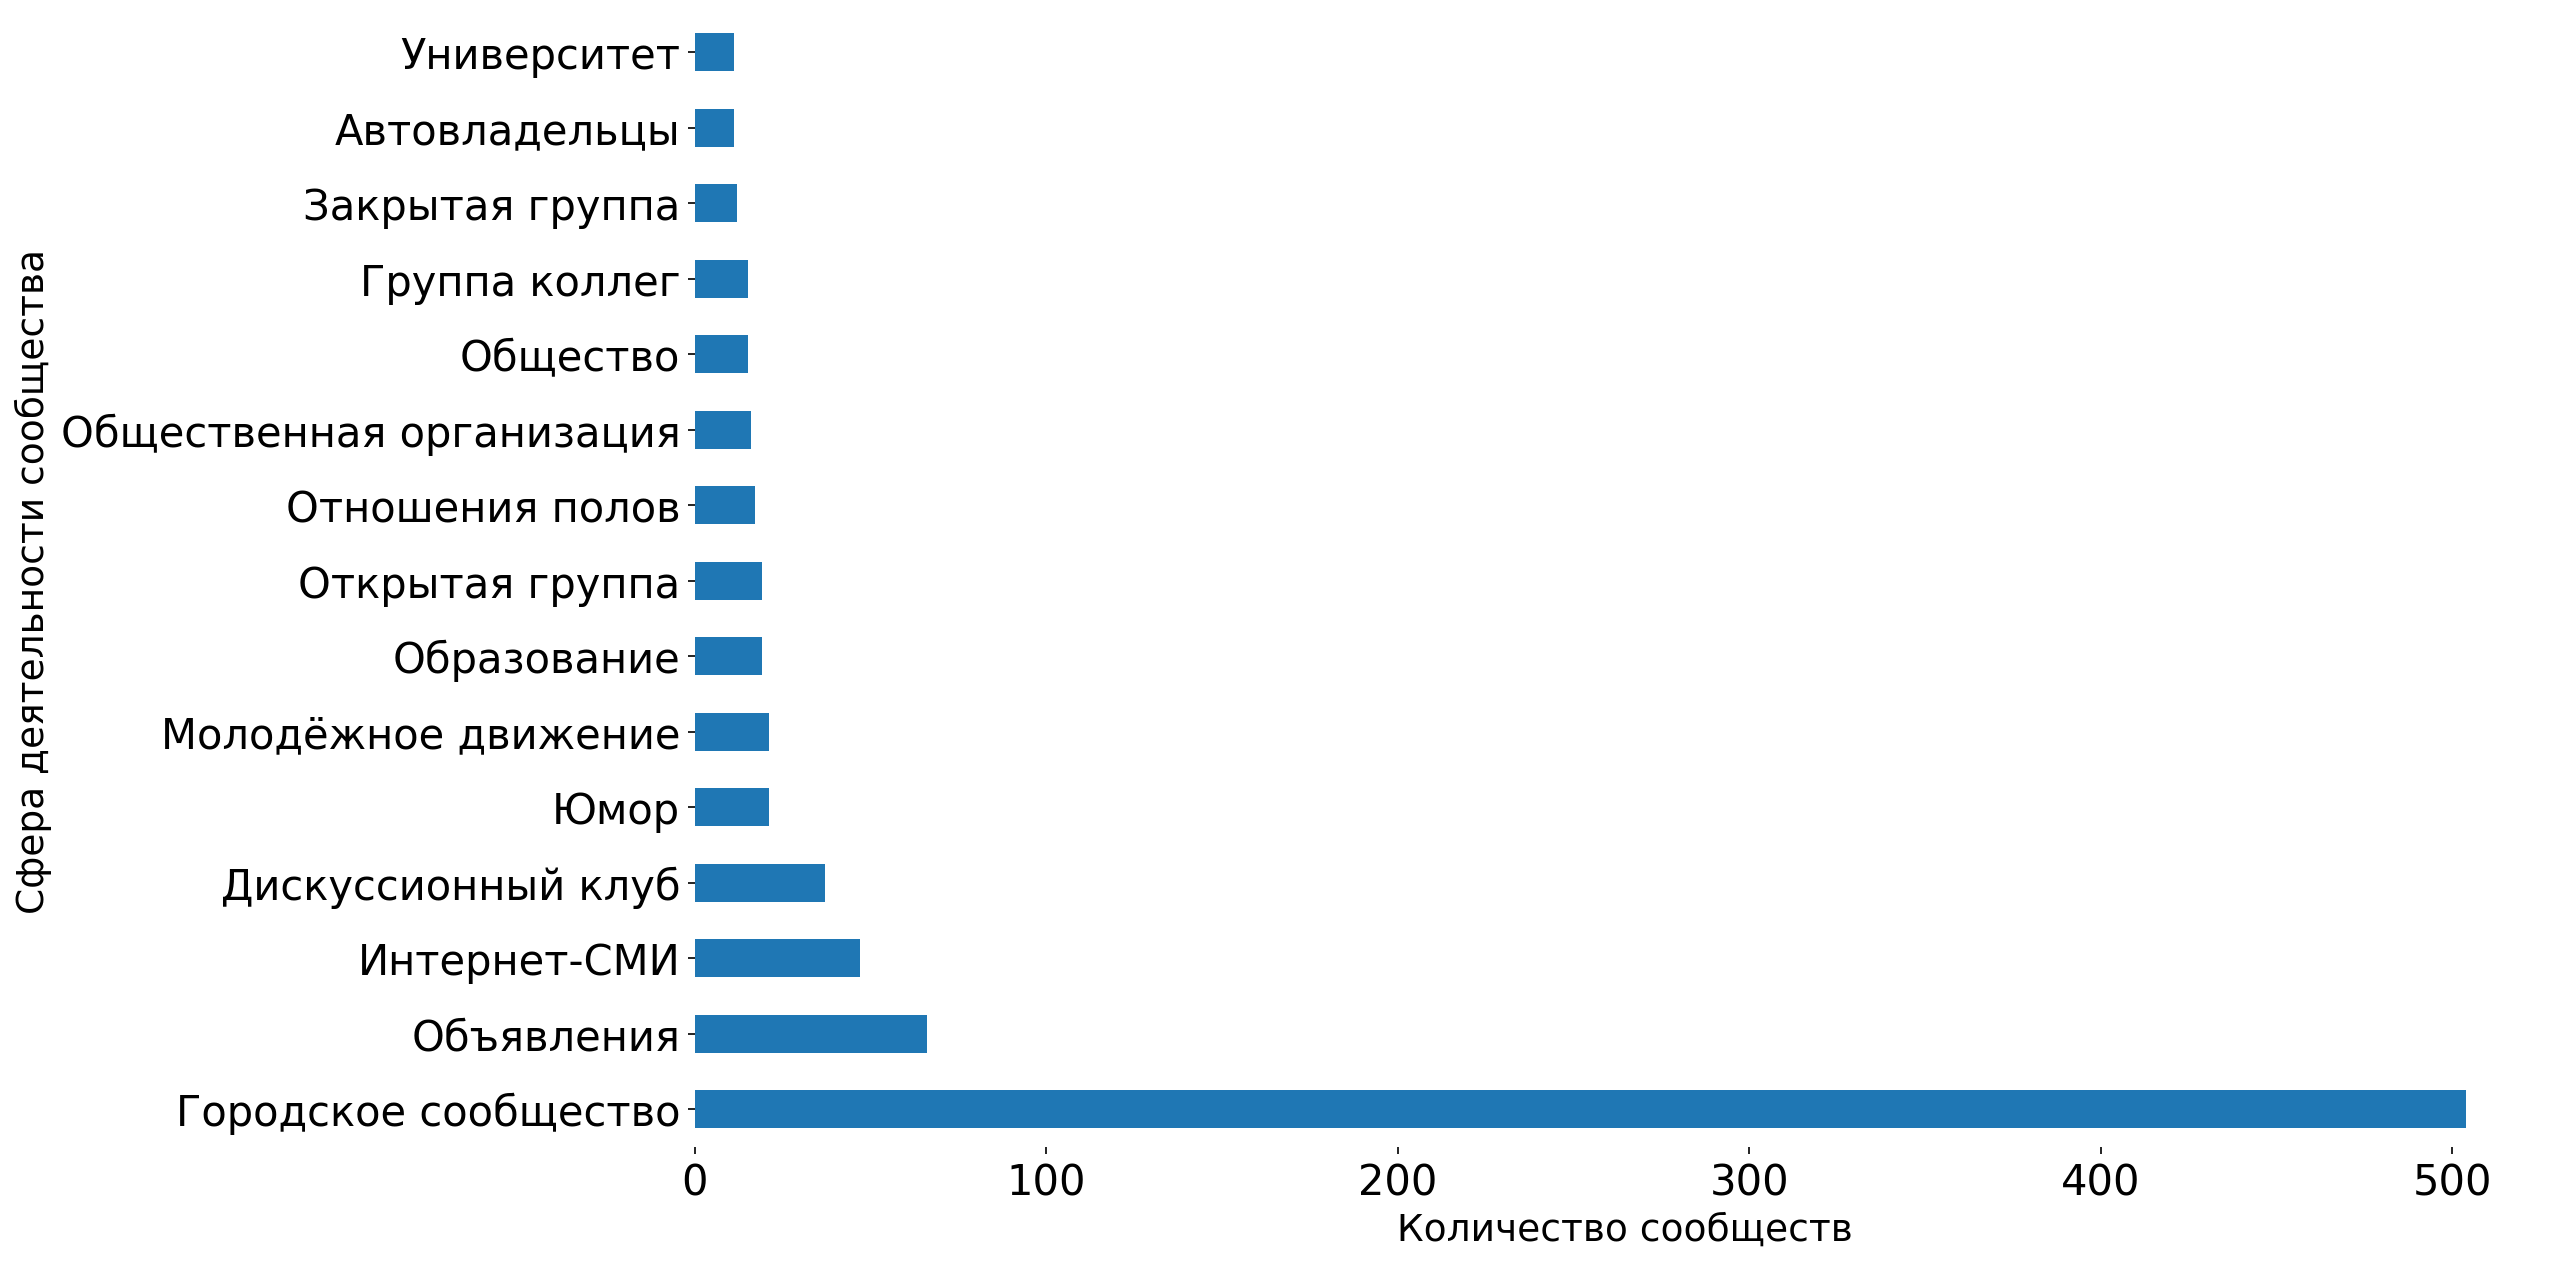

In [40]:
ax = df_counts.plot.barh(x='Сфера сообщества', y='Количество групп',
                 figsize=(16,10), fontsize=20, legend=False)
ax.set_ylabel('Сфера деятельности сообщества',fontdict={'fontsize':18})
ax.set_xlabel('Количество сообществ',fontdict={'fontsize':18})
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

In [ ]:
# ax.figure.savefig('activ_barhplot.jpg',
#                   bbox_inches='tight',
#                   pad_inches=1)

In [41]:
#check groups with over 0.5 mln subscribers
df[df.users_new > 500000]

,name,activity,users,users_new
0,Подслушано – Здесь говорят о тебе,Общество,4 015 622 подписчика,4015622
1,Подслушано | Пошлое 18+ 16+,Эротика,734 173 подписчика,734173
2,Подслушано Метро Москвы,Городское сообщество,633 333 подписчика,633333
